<a href="https://colab.research.google.com/github/jaim3s/Cellular-automaton-infections/blob/main/cellular_automaton_infections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cellular automaton for infections**

The components of the cellular automaton are:

* **Reticulate**

The reticulate is a $n \times m$ matrix.

* **States**

The states or alphabet is conformed for the next elements


1. EC = Empty cell
2. HP = Healthy person
3. IPS = Infected person symptomatic
4. IPA = Infected person asymptomatic
5. IPM = Infected person with medical assist
6. CP = Cured person
7. DP = Dead person

* **Neighborhood of the reticulate**

The neighborhood of the cellular automaton is the neighborhood of Moore.
![neigh](https://drive.google.com/uc?export=view&id=1YvSBr8We_hLdRPJgC4f_v1CFg75cQlY5)

* **Transition function**

We define the transition function as the follow set of rules:

1. If HP have $n$ neighbors have a probability of $0.n$ of change the state to IPS or IPA.
2. To change to IPS have a probability of 0.3
3. To change to IPA have a probability of 0.7
4. After 7 cycles IPS pass to IPM
5. After 30 cycles IPA pass to CP
6. After 20 cycles IPM pass to CP with probability of 0.8 and pass to DP with probability of 0.2
7. When all the rules are executed, shift each cell to up, down, right or left cell with a probability of 0.25 only if the cell is empty (EC).

* **Initial configuration**

The initial configuration is:

1. 5000 as HP
2. 5 as IPS
3. 5 as IPA

Each cell is localizate with uniform distribution on a grid of size $n\times m$.






0: 100
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0



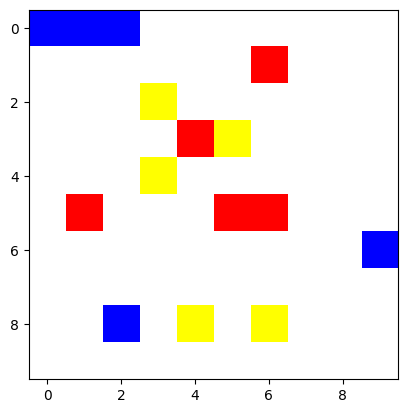

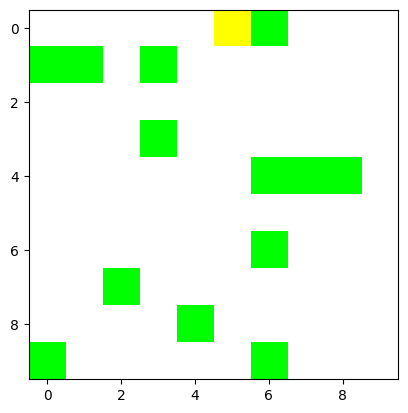

0: 85
1: 0
2: 1
3: 0
4: 0
5: 13
6: 1



In [2]:
import matplotlib.pyplot as plt
from typing import List
import random
import copy

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
YELLOW = (255, 255, 0)
PINK = (255, 0, 255)

def generate_indices(n: int, high: int) -> List[tuple]:
    """
    Generate random indices.

        Parameters:
            n (int): Number of indices to generate
            high (int): maximun value of the indices

        Returns:
            return a list with n indices.
    """

    unique_indices = []
    while len(unique_indices) < n:
        tuple_ = (random.randint(0, high), random.randint(0, high))
        if tuple_ not in unique_indices:
            unique_indices.append(tuple_)
    return unique_indices

def initial_configuration(grid: "Grid", states: dict, stats: "Stats"):
    """
    Stablish initial configuration of the CA.

        Parameters:
            grid ("Grid"): Grid of the CA
            states (dict): Dictionary with the state and colors
            stats ("Stats"): Stats of the CA

        Returns:
            return the initial configuration.
    """

    healthy_cells = grid.width//2
    # Generate unique indices
    indices = generate_indices(healthy_cells+10, grid.width-1)
    for k, idx in enumerate(indices):
        if k < healthy_cells:
            grid.values[idx[0]][idx[1]].change_state(states, 1)
            stats.replace(1, 0)
        elif k < healthy_cells+5:
            grid.values[idx[0]][idx[1]].change_state(states, 2)
            stats.replace(2, 0)
        else:
            grid.values[idx[0]][idx[1]].change_state(states, 3)
            stats.replace(3, 0)


def transition_func(grid: "Grid", i: int, j: int, neighborhood: List[tuple], states: dict, stats: "Stats") -> None:
    """
    Transition function of the CA.

        Parameters:
            grid ("Grid"): grid of the CA
            i (int): Row of the current cell
            j (int): Column of the current cell
            neighborhood (List[tuple]): List with neighborhood of moore for i and j
            states (dict): Dictionary with the state and colors
            stats ("Stats"): Stats of the CA

        Returns:
            return None.
    """

    if grid.values[i][j].state == 1:
        res = 0
        for h,k in neighborhood:
            if grid.values[h][k].state != 0:
                res += 1
        # Probability of change of state
        if random.random() <= res/10:
                # Symptomatic
            if random.random() < 0.3:
                grid.values[i][j].change_state(states, 2)
                stats.replace(2, 1)
            # Asymptomatic
            else:
                grid.values[i][j].change_state(states, 3)
                stats.replace(3, 1)
    elif grid.values[i][j].state == 2 and grid.values[i][j].cycle == 7:
        grid.values[i][j].change_state(states, 4)
        stats.replace(4, 2)
    elif grid.values[i][j].state == 3 and grid.values[i][j].cycle == 30:
        grid.values[i][j].change_state(states, 5)
        stats.replace(5, 3)
    elif grid.values[i][j].state == 4 and grid.values[i][j].cycle == 20:
        # Cured person
        if random.random() < 0.8:
            grid.values[i][j].change_state(states, 5)
            stats.replace(5, 4)
        # Dead person
        else:
            grid.values[i][j].reset(states)
            stats.replace(6, 4)
    # Move cell
    if grid.values[i][j].state != 0:
        shift = random.choice([1,4,3,6])
        for k in [1,4,3,6]:
            if grid.values[neighborhood[k][0]][neighborhood[k][1]].state == 0 and shift == k:
                grid.values[neighborhood[k][0]][neighborhood[k][1]] = copy.deepcopy(grid.values[i][j])
                grid.values[i][j].reset(states)

def moore_neighborhood(grid: "Grid", i: int, j: int) -> List[list]:
    """
    Get the neighborhood of Moore.

        Parameters:
            grid ("Grid"): grid of the CA
            i (int): i index
            j (int): j index

        Returns:
            return a list with the indeces to belong to the neighborhood of Moore.
    """

    neighborhood = []
    for di in range(-1, 2):
        for dj in range(-1, 2):
            ni = (i + di) % len(grid)
            nj = (j + dj) % len(grid[0])
            if ni != i or nj != j:  # Skip the current cell itself
                neighborhood.append((ni, nj))
    return neighborhood

class Cell:
    def __init__(self, state=0, color=(255,255,255), cycle=0):
        self.state = state
        self.color = color
        self.cycle = cycle

    def change_state(self, states: dict, new_state: object) -> None:
        """
        Change the current state of the cell.

            Parameters:
                states (dict): All the possible states
                new_state (object): New state

            Returns:
                return None
        """

        self.state = new_state
        self.color = states[new_state]

    def reset(self, states) -> None:
        """
        Reset all the attributes to its default values.

            Parameters:
                None

            Returns:
                return None
        """

        self.state = 0
        self.color = states[0]
        self.cycle = 0

    def __str__(self) -> str:
        """
        Get the content of the cell as a string.

            Parameters:
                None

            Returns:
                return the content of the cell in a string
        """

        return self.state

class CellularAutomaton:
    def __init__(self, grid: "Grid", neighborhood: List[list], states: List[object], transition_func: object, initial_configuration: object, stats: "Stats", n: int):
        self.grid = grid
        self.neighborhood = neighborhood
        self.states = states
        self.transition_func = transition_func
        self.initial_configuration = initial_configuration
        self.stats = stats
        self.n = n

    def update(self, states) -> None:
        """
        Update the information of the CA.

            Parameters:
                None

            Returns:
                return None
        """

        for i in range(self.grid.height):
            for j in range(self.grid.width):
                self.grid.values[i][j].cycle += 1
                self.transition_func(self.grid, i, j, self.neighborhood(self.grid.values, i, j), states, self.stats)

    def run(self, states, *args: List[object]) -> None:
        """
        Set the initial configuration in the grid and execute the automaton.

            Parameters:
                None

            Returns:
                return None
        """

        # Set initial configuration
        self.initial_configuration(*args, states, self.stats)
        self.grid.plot()
        for i in range(self.n):
            self.update(states)
        self.grid.plot()

class Stats:
    def __init__(self, stats: dict):
        self.stats = stats

    def replace(self, key1: object, key2: object) -> None:
        """
        Add 1 to the stat key1 and substract 1 to the stat key2.

            Parameters:
                key1 (object): Key to add the value
                key2 (object): key to substract the value

            Returns:
                return None.
        """

        self.stats[key1] += 1
        self.stats[key2] -= 1

    def __str__(self) -> str:
        """
        Get the content of the stats attribute as a string.

            Parameters:
                None

            Returns:
                return the content of the stats in a string
        """

        res = ""
        for key in self.stats:
            res += str(key) + ": " +  str(self.stats[key]) + "\n"
        return res

class Grid:
    def __init__(self, width: int, height: int):
        self.width = width
        self.height = height
        self.values = [[Cell() for _ in range (self.width)] for _ in range(self.height)]

    def __str__(self) -> str:
        """
        Get the content of the values attributes as a string.

            Parameters:
                None

            Returns:
                return the content of the values in a string
        """

        res = ""
        for row in range(self.height):
            for col in range(self.width):
                res += str(self.values[row][col]) + " "
            res += "\n"
        return res

    def plot(self) -> None:
        """
        Plot the content of the grid.

            Parameters:
                None

            Returns:
                return None
        """

        colors = [[self.values[i][j].color for j in range(self.width)] for i in range(self.height)]

        # Plot the matrix
        plt.imshow(colors)
        plt.show()


def main():

    width, height = 10, 10
    grid = Grid(width, height)
    states = {0:WHITE, 1:BLUE, 2:YELLOW, 3:RED, 4:PINK, 5:GREEN, 6:BLACK}
    stats = Stats({0:grid.width*grid.width, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0})
    ca = CellularAutomaton(grid, moore_neighborhood, states, transition_func, initial_configuration, stats, 120)
    print(ca.stats)
    ca.run(states, grid)
    print(ca.stats)

if __name__ == "__main__":
    main()

### Animation test

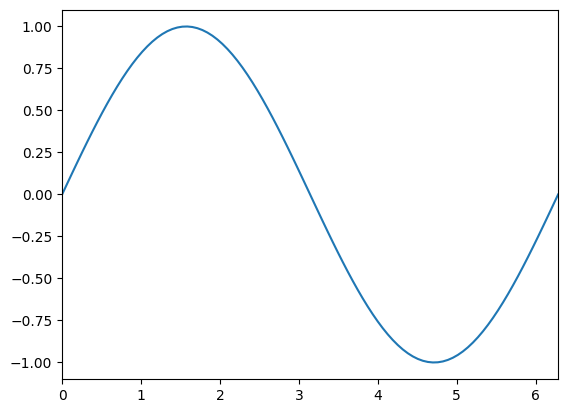

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

x = np.linspace(0, 2*np.pi, 100)

fig = plt.figure()

lines = plt.plot([])
line = lines[0]

plt.xlim(0, 2*np.pi)
plt.ylim(-1.1, 1.1)

def animate(frame):
    # Update plot
    y = np.sin(x + 2*np.pi*frame/100)
    line.set_data((x, y))

anim = FuncAnimation(fig, animate, frames=100, interval=20)
HTML(anim.to_html5_video())

